In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

err_tol = {
    'challenge': [ 0.30, 0.40, 0.50, 0.60, 0.70 ],
    'play': [ 0.15, 0.20, 0.25, 0.30, 0.35 ],
    'throwin': [ 0.15, 0.20, 0.25, 0.30, 0.35 ]
}

video_id_split = {
    'val':[
         '3c993bd2_0',
         '3c993bd2_1',
    ],
    'train':[
         '1606b0e6_0',
         '1606b0e6_1',
         '35bd9041_0',
         '35bd9041_1',
         '407c5a9e_1',
         '4ffd5986_0',
         '9a97dae4_1',
         'cfbe2e94_0',
         'cfbe2e94_1',
         'ecf251d4_0',
    ]
}

event_names = ['challenge', 'throwin', 'play']

event_names_with_background = ['background','challenge','play','throwin']

label_dict = {
    'background':0,
    'challenge':1,
    'play':2,
    'throwin':3,
}

In [126]:
def rolling_window(arr, window):
    shape = (arr.shape[0] - window + 1,) + (arr.shape[1] * window,)
    strides = (arr.shape[1] * arr.itemsize, arr.itemsize)
    return np.lib.stride_tricks.as_strided(arr, shape = shape, strides = strides)

video_id = video_id_split['train'][9]
df_result = pd.read_csv(f'result/result_{video_id}.csv')
df_input = df_result.drop(columns = ['video_id', 'frame_id'])
df_len = len(df_input)
df_input = pd.concat([pd.DataFrame(index = [-7, -6, -5, -4, -3, -2, -1]), df_input, pd.DataFrame(index = [df_len, df_len + 1, df_len + 2, df_len + 3, df_len + 4, df_len + 5, df_len + 6])]).fillna(0)
# df_input = pd.concat([pd.DataFrame(index = [-2, -1]), df_input, pd.DataFrame(index = [df_len, df_len + 1,])]).fillna(0)
idx_input = []
for i in range(df_len):
    idx_input.append(i - 7)
    idx_input.append(i - 6)
    idx_input.append(i - 5)
    idx_input.append(i - 4)
    idx_input.append(i - 3)
    idx_input.append(i - 2)
    idx_input.append(i - 1)
    idx_input.append(i)
    idx_input.append(i + 1)
    idx_input.append(i + 2)
    idx_input.append(i + 3)
    idx_input.append(i + 4)
    idx_input.append(i + 5)
    idx_input.append(i + 6)
    idx_input.append(i + 7)
df_input = df_input.loc[idx_input]
features_numpy = df_input.values.reshape(-1, 990)
featuresTest = torch.from_numpy(features_numpy).type(torch.FloatTensor) # data type is float

# Pytorch train and test sets
test = torch.utils.data.TensorDataset(featuresTest)
test_loader = DataLoader(test, batch_size = 500, shuffle = False)

In [131]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True) # batch_first=True (batch_dim, seq_dim, feature_dim)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # 28 time steps
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach().cuda(), c0.detach().cuda()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
input_dim = 66
hidden_dim = 128
layer_dim = 1
output_dim = 4
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim).cuda()

error = nn.CrossEntropyLoss()

learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

model.load_state_dict(torch.load('LSTM_count5000_acc85.pt'))

<All keys matched successfully>

In [132]:
seq_dim = 15
outputs = model(featuresTest.view(-1, seq_dim, input_dim).cuda())
prob_test = torch.softmax(outputs, -1)
# prob_test = torch.max(prob_test.data, 1)[1]
# prob_test = nn.functional.one_hot(prob_test, num_classes=4)
prob_test = prob_test.cpu().detach().numpy()
# prob_test = outputs.cpu().detach().numpy()
np.save(f"prob_test_{video_id}.npy", prob_test)

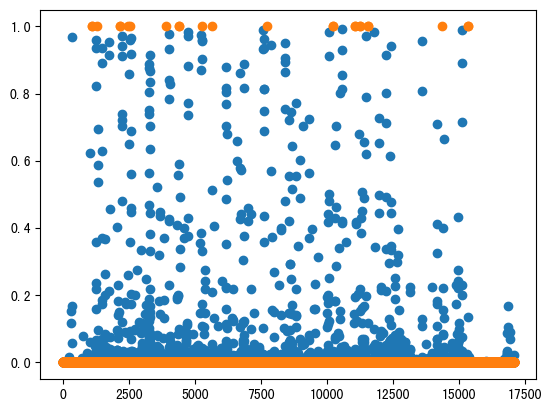

In [133]:
import matplotlib.pyplot as plt
prob_right = pd.read_csv(f'result/result_labeled_{video_id}.csv').label.map(label_dict).values
prob_right = nn.functional.one_hot(torch.from_numpy(prob_right), num_classes=4)
df = pd.DataFrame(prob_test, columns = ['background','challenge','play','throwin'])
df_right = pd.DataFrame(prob_right, columns = ['background','challenge','play','throwin'])
x_min = 5000
x_max = x_min+5000
# plt.xlim((x_min,x_max))
plt.scatter(df.index, df.throwin)
plt.scatter(df.index, df_right.throwin)

In [10]:
# copy from https://www.kaggle.com/code/ryanholbrook/competition-metric-dfl-event-detection-ap

import numpy as np
import pandas as pd
from pandas.testing import assert_index_equal
from typing import Dict, Tuple

tolerances = {
    "challenge": [0.3, 0.4, 0.5, 0.6, 0.7],
    "play": [0.15, 0.20, 0.25, 0.30, 0.35],
    "throwin": [0.15, 0.20, 0.25, 0.30, 0.35],
}
            

def filter_detections(
        detections: pd.DataFrame, intervals: pd.DataFrame
) -> pd.DataFrame:
    """Drop detections not inside a scoring interval."""
    detection_time = detections.loc[:, 'time'].sort_values().to_numpy()
    intervals = intervals.to_numpy()
    is_scored = np.full_like(detection_time, False, dtype=bool)

    i, j = 0, 0
    while i < len(detection_time) and j < len(intervals):
        time = detection_time[i]
        int_ = intervals[j]

        # If the detection is prior in time to the interval, go to the next detection.
        if time < int_.left:
            i += 1
        # If the detection is inside the interval, keep it and go to the next detection.        
        elif time in int_:
            is_scored[i] = True
            i += 1
        # If the detection is later in time, go to the next interval.
        else:
            j += 1

    return detections.loc[is_scored].reset_index(drop=True)


def match_detections(
        tolerance: float, ground_truths: pd.DataFrame, detections: pd.DataFrame
) -> pd.DataFrame:
    """Match detections to ground truth events. Arguments are taken from a common event x tolerance x video evaluation group."""
    detections_sorted = detections.sort_values('score', ascending=False).dropna()

    is_matched = np.full_like(detections_sorted['event'], False, dtype=bool)
    gts_matched = set()
    for i, det in enumerate(detections_sorted.itertuples(index=False)):
        best_error = tolerance
        best_gt = None

        for gt in ground_truths.itertuples(index=False):
            error = abs(det.time - gt.time)
            if error < best_error and not gt in gts_matched:
                best_gt = gt
                best_error = error
            
        if best_gt is not None:
            is_matched[i] = True
            gts_matched.add(best_gt)

    detections_sorted['matched'] = is_matched

    return detections_sorted


def precision_recall_curve(
        matches: np.ndarray, scores: np.ndarray, p: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if len(matches) == 0:
        return [1], [0], []

    # Sort matches by decreasing confidence
    idxs = np.argsort(scores, kind='stable')[::-1]
    scores = scores[idxs]
    matches = matches[idxs]
    
    distinct_value_indices = np.where(np.diff(scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, matches.size - 1]
    thresholds = scores[threshold_idxs]
    
    # Matches become TPs and non-matches FPs as confidence threshold decreases
    tps = np.cumsum(matches)[threshold_idxs]
    fps = np.cumsum(~matches)[threshold_idxs]
    
    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = tps / p  # total number of ground truths might be different than total number of matches
    
    # Stop when full recall attained and reverse the outputs so recall is non-increasing.
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)

    # Final precision is 1 and final recall is 0
    return np.r_[precision[sl], 1], np.r_[recall[sl], 0], thresholds[sl]


def average_precision_score(matches: np.ndarray, scores: np.ndarray, p: int) -> float:
    precision, recall, _ = precision_recall_curve(matches, scores, p)
    # Compute step integral
    return -np.sum(np.diff(recall) * np.array(precision)[:-1])


def event_detection_ap(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        tolerances: Dict[str, float],
) -> float:

    assert_index_equal(solution.columns, pd.Index(['video_id', 'time', 'event']))
    assert_index_equal(submission.columns, pd.Index(['video_id', 'time', 'event', 'score']))

    # Ensure solution and submission are sorted properly
    solution = solution.sort_values(['video_id', 'time'])
    submission = submission.sort_values(['video_id', 'time'])
    
    # Extract scoring intervals.
    intervals = (
        solution
        .query("event in ['start', 'end']")
        .assign(interval=lambda x: x.groupby(['video_id', 'event']).cumcount())
        .pivot(index='interval', columns=['video_id', 'event'], values='time')
        .stack('video_id')
        .swaplevel()
        .sort_index()
        .loc[:, ['start', 'end']]
        .apply(lambda x: pd.Interval(*x, closed='both'), axis=1)
    )

    # Extract ground-truth events.
    ground_truths = (
        solution
        .query("event not in ['start', 'end']")
        .reset_index(drop=True)
    )

    # Map each event class to its prevalence (needed for recall calculation)
    class_counts = ground_truths.value_counts('event').to_dict()

    # Create table for detections with a column indicating a match to a ground-truth event
    detections = submission.assign(matched = False)

    # Remove detections outside of scoring intervals
    detections_filtered = []
    for (det_group, dets), (int_group, ints) in zip(
        detections.groupby('video_id'), intervals.groupby('video_id')
    ):
        assert det_group == int_group
        detections_filtered.append(filter_detections(dets, ints))
    detections_filtered = pd.concat(detections_filtered, ignore_index=True)

    # Create table of event-class x tolerance x video_id values
    aggregation_keys = pd.DataFrame(
        [(ev, tol, vid)
         for ev in tolerances.keys()
         for tol in tolerances[ev]
         for vid in ground_truths['video_id'].unique()],
        columns=['event', 'tolerance', 'video_id'],
    )

    # Create match evaluation groups: event-class x tolerance x video_id
    detections_grouped = (
        aggregation_keys
        .merge(detections_filtered, on=['event', 'video_id'], how='left')
        .groupby(['event', 'tolerance', 'video_id'])
    )
    ground_truths_grouped = (
        aggregation_keys
        .merge(ground_truths, on=['event', 'video_id'], how='left')
        .groupby(['event', 'tolerance', 'video_id'])
    )
    
    # Match detections to ground truth events by evaluation group
    detections_matched = []
    for key in aggregation_keys.itertuples(index=False):
        dets = detections_grouped.get_group(key)
        gts = ground_truths_grouped.get_group(key)
        detections_matched.append(
            match_detections(dets['tolerance'].iloc[0], gts, dets)
        )
    detections_matched = pd.concat(detections_matched)
    
    # Compute AP per event x tolerance group
    event_classes = ground_truths['event'].unique()
    ap_table = (
        detections_matched
        .query("event in @event_classes")
        .groupby(['event', 'tolerance']).apply(
        lambda group: average_precision_score(
        group['matched'].to_numpy(),
                group['score'].to_numpy(),
                class_counts[group['event'].iat[0]],
            )
        )
    )

    # Average over tolerances, then over event classes
    mean_ap = ap_table.groupby('event').mean().mean()
    # print(ap_table.groupby('event').mean())

    return ap_table

solution = pd.read_csv("../input/dfl-bundesliga-data-shootout/train.csv", usecols=['video_id', 'time', 'event'])

In [134]:
def make_sub(prob, df_result):
    
    frame_rate = 25
    window_size = 1
    ignore_width = 2

    df = pd.DataFrame(prob,columns=event_names_with_background)
    df['video_id'] = df_result.video_id
    df['frame_id'] = df_result.frame_id

    train_df = []
    for video_id,gdf in df.groupby('video_id'):
        for i, event in enumerate(event_names):
            # print(video_id, event)
            prob_arr = gdf[event].rolling(window=window_size, center=True).mean().fillna(-100).values
            sort_arr = np.argsort(-prob_arr)
            rank_arr = np.empty_like(sort_arr)
            rank_arr[sort_arr] = np.arange(len(sort_arr))
            idx_list = []
            for i in range(len(prob_arr)):
                this_idx = sort_arr[i]
                if this_idx >= 0:
                    idx_list.append(this_idx)
                    for parity in (-1,1):
                        for j in range(1, ignore_width+1):
                            ex_idx = this_idx + j * parity
                            if ex_idx >= 0 and ex_idx < len(prob_arr):
                                sort_arr[rank_arr[ex_idx]] = -1
            this_df = gdf.reset_index(drop=True).iloc[idx_list].reset_index(drop=True)
            this_df["score"] = prob_arr[idx_list]
            this_df['event'] = event
            train_df.append(this_df)
    train_df = pd.concat(train_df)
    train_df['time'] = train_df['frame_id']/frame_rate
    
    return train_df.reset_index(drop=True)

test_df = make_sub(prob_test, df_result)
score = event_detection_ap(solution[solution['video_id'].isin(test_df['video_id'].unique())], test_df[['video_id', 'time', 'event', 'score']], tolerances)
print(score)
print(score.groupby('event').mean())
print(score.mean())

event      tolerance
challenge  0.30         0.030636
           0.40         0.042890
           0.50         0.045825
           0.60         0.050257
           0.70         0.056501
play       0.15         0.067802
           0.20         0.090549
           0.25         0.133076
           0.30         0.184231
           0.35         0.224860
throwin    0.15         0.007875
           0.20         0.009127
           0.25         0.016795
           0.30         0.018121
           0.35         0.018413
dtype: float64
event
challenge    0.045222
play         0.140104
throwin      0.014066
dtype: float64
0.06646395532718909
